Explore trends in experimental data

In [6]:
from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

%matplotlib inline

In [7]:
split_data = {}
cell_types =  ["HepG2", "K562"]
promoters = ["SV40P", "minP"]
design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

for cell_type in cell_types:
    for promoter in promoters:
        experiment_key = (cell_type, promoter)
        split_data[experiment_key] = {}
        for design_name in design_names:
            with open("../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()
                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        assert key not in split_data[experiment_key]
                        split_data[experiment_key][key] = (val, 0)

            with open("../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()
                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1" and key in split_data[experiment_key]:
                        assert split_data[experiment_key][key][1] == 0
                        split_data[experiment_key][key] = (split_data[experiment_key][key][0], val)

print "Data from experiment {}:".format(split_data.items()[0][0])
pprint(split_data.items()[0][1].items()[:5])

Data from experiment ('HepG2', 'minP'):
[('Huvec_15_5_12_chr9_134025315', (0.43110373753918907, -2.2286335886192603)),
 ('K562_7_2_10_chr5_77817535', (-2.1637144638359445, -3.2164629829432343)),
 ('K562_8_39_18_chr11_5602495', (-0.2852792348800577, -1.57003526420052)),
 ('Huvec_5_556_25_chr16_3727095', (1.0151357673858534, -2.359540846608798)),
 ('Hepg2_8_141_16_chr7_514575', (1.5192431698261224, 2.117045493067561))]


In [8]:
data = {}
for experiment_key, key_to_split in split_data.items():
    data[experiment_key] = {}
    for key, val in key_to_split.items():
        data[experiment_key][key] = sum(list(split_data[experiment_key][key])) / 2.0
    

In [9]:
valid_keys = list(reduce(
    lambda acc, d: acc.intersection(d.keys()), 
    data.values()[1:], 
    set(data.values()[0].keys())
))

print "{} sequences have measurements for all tasks.".format(len(valid_keys))

277409 sequences have measurements for all tasks.


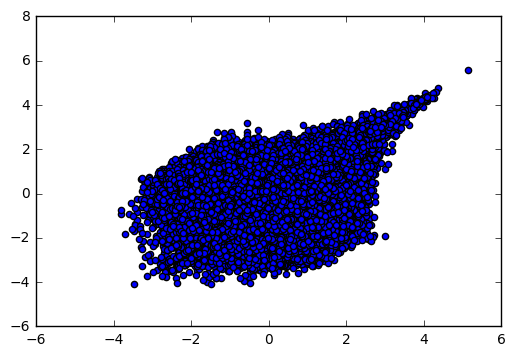

('HepG2', 'minP')
[[ 1.0000036   0.32542667]
 [ 0.32542667  1.0000036 ]] (2, 277409)


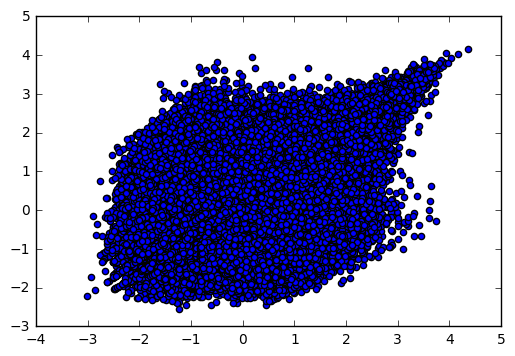

('K562', 'minP')
[[ 1.0000036   0.36576822]
 [ 0.36576822  1.0000036 ]] (2, 277409)


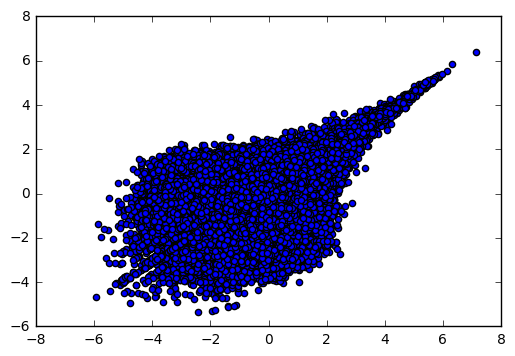

('HepG2', 'SV40P')
[[ 1.0000036   0.45198875]
 [ 0.45198875  1.0000036 ]] (2, 277409)


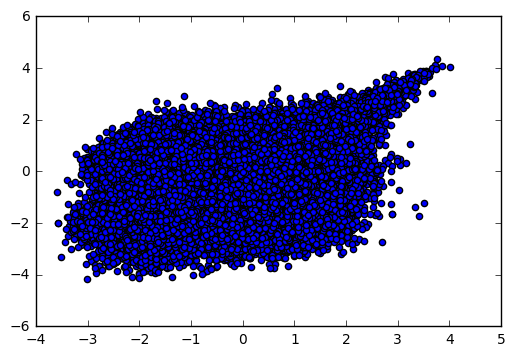

('K562', 'SV40P')
[[ 1.0000036   0.46768978]
 [ 0.46768978  1.0000036 ]] (2, 277409)


In [10]:
# Variance between replicates
for experiment_key, key_to_normalized in split_data.items():
    vals = np.array([scale([key_to_normalized[key][0] for key in valid_keys]),
                 scale([key_to_normalized[key][1] for key in valid_keys])])
    plt.scatter(vals[0, :], vals[1, :])
    plt.show()
    print experiment_key
    print np.cov(vals), vals.shape

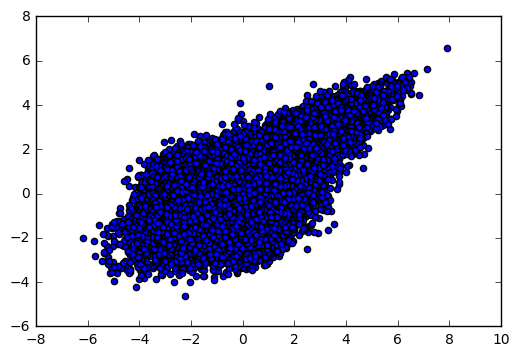

HepG2
[[ 1.0000036   0.48362842]
 [ 0.48362842  1.0000036 ]] (2, 277409)
-6.19847741255e-17


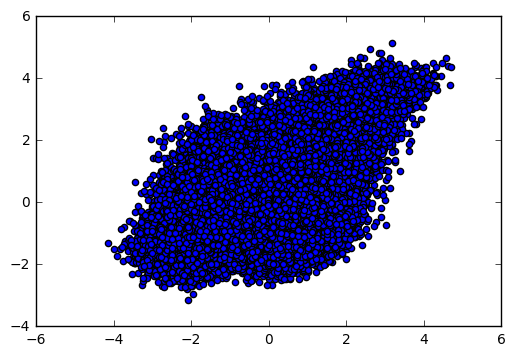

K562
[[ 1.0000036   0.45608595]
 [ 0.45608595  1.0000036 ]] (2, 277409)
1.08489363184e-17


In [11]:
# Variance between promotors
for cell_type in cell_types:
    vals = np.array([scale([data[(cell_type, promoter)][key] for key in valid_keys]) for promoter in promoters])
    plt.scatter(vals[0], vals[1])
    plt.show()
    print cell_type
    print np.cov(vals), vals.shape
    print np.mean(vals)

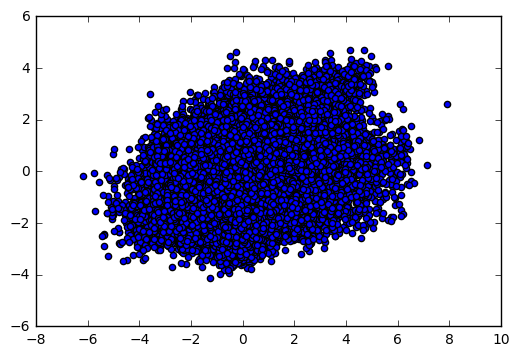

SV40P [[ 1.0000036   0.27417225]
 [ 0.27417225  1.0000036 ]] (2, 277409)
-2.38462085582e-17


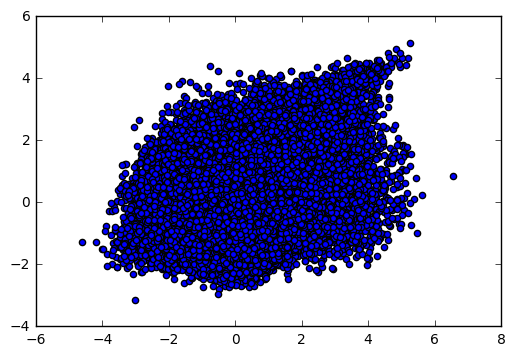

minP [[ 1.0000036   0.32451006]
 [ 0.32451006  1.0000036 ]] (2, 277409)
-2.8288557427e-17


In [12]:
# Variance between cell types
for promoter in promoters:
    vals = np.array([scale([data[(cell_type, promoter)][key] for key in valid_keys]) for cell_type in cell_types])
    plt.scatter(vals[0], vals[1])
    plt.show()
    print promoter, np.cov(vals), vals.shape
    print np.mean(vals)

In [13]:
def plot_scaled(scaler, d = data):
    for experiment_key, key_to_normalized in d.items():
        vals = scaler(np.array([key_to_normalized[key] for key in valid_keys]).reshape(-1, 1))
        plt.hist(vals, bins = 100)
        plt.title(experiment_key)
        plt.show()
        print "Variance for {} is {}".format(experiment_key, np.var(vals))
        print "Min is {} and Max is {}".format(np.min((vals)), np.max(vals))
        print "Mean is {}".format(np.mean(vals))

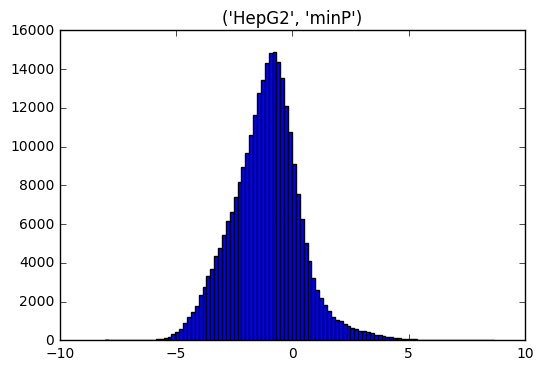

Variance for ('HepG2', 'minP') is 2.23285443253
Min is -8.04820671461 and Max is 8.68406510524
Mean is -1.12974140944


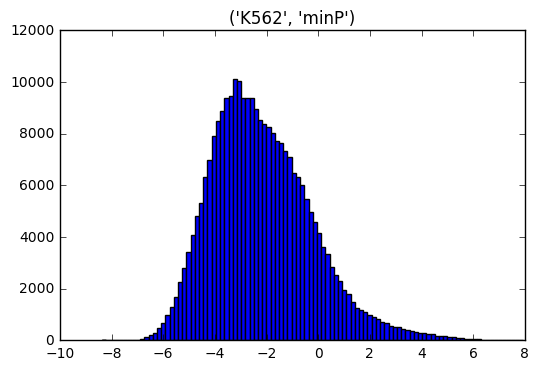

Variance for ('K562', 'minP') is 3.87033486122
Min is -8.36313579427 and Max is 7.93556542131
Mean is -2.18002019293


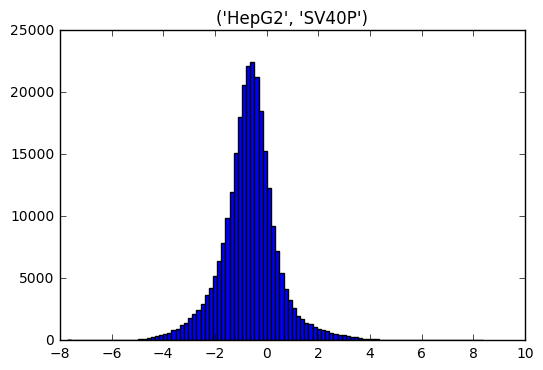

Variance for ('HepG2', 'SV40P') is 1.30145165011
Min is -7.70049169401 and Max is 8.37099300631
Mean is -0.663190499863


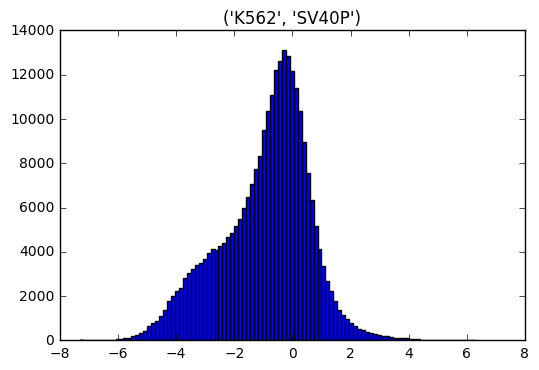

Variance for ('K562', 'SV40P') is 2.3714612357
Min is -7.31382998171 and Max is 6.31441517117
Mean is -0.941689273514


In [14]:
plot_scaled(lambda x: x)

Scale all the (normalized) measurements so they are between -1 and 1.

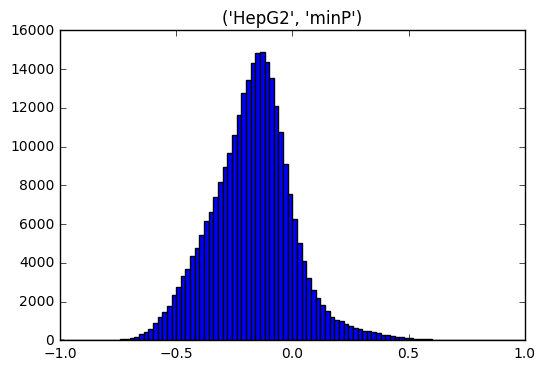

Variance for ('HepG2', 'minP') is 0.0319014614981
Min is -1.0 and Max is 1.0
Mean is -0.17303933624


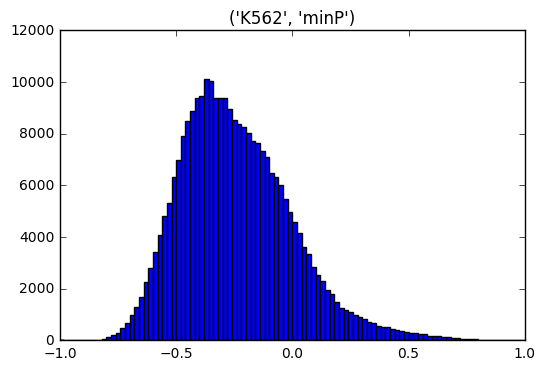

Variance for ('K562', 'minP') is 0.0582777178171
Min is -1.0 and Max is 1.0
Mean is -0.241275053815


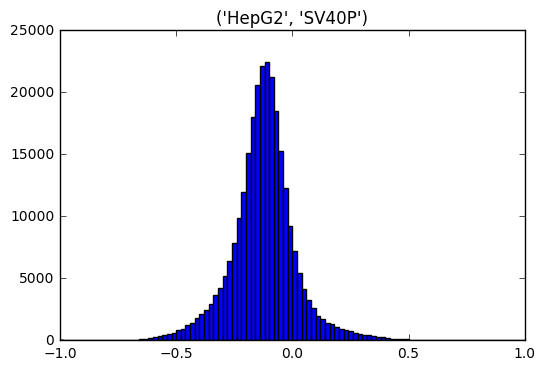

Variance for ('HepG2', 'SV40P') is 0.0201546857626
Min is -1.0 and Max is 1.0
Mean is -0.124250021032


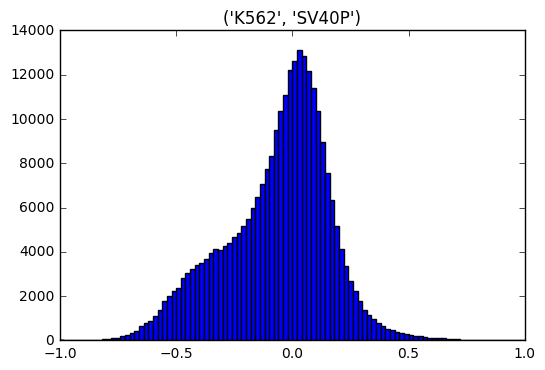

Variance for ('K562', 'SV40P') is 0.0510735618813
Min is -1.0 and Max is 1.0
Mean is -0.064862623659


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
plot_scaled(scaler.fit_transform)

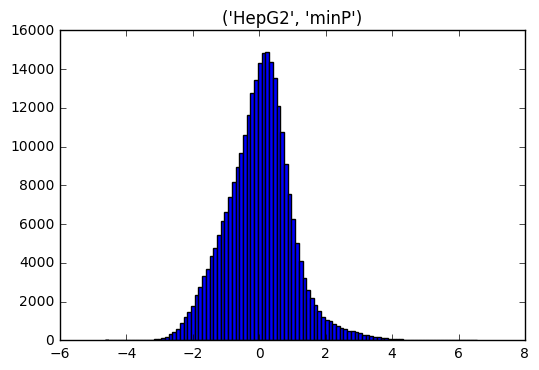

Variance for ('HepG2', 'minP') is 1.0
Min is -4.62998476481 and Max is 6.56760894844
Mean is -4.65654212232e-17


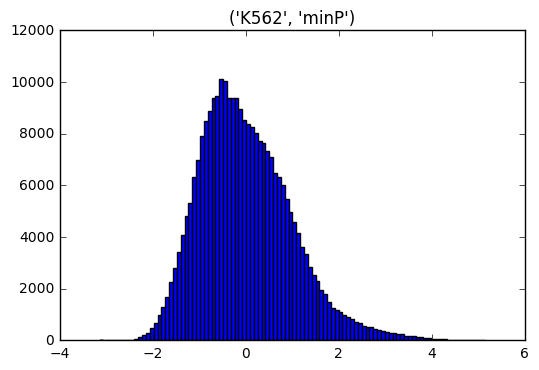

Variance for ('K562', 'minP') is 1.0
Min is -3.14291832661 and Max is 5.14181869809
Mean is -9.72033957878e-18


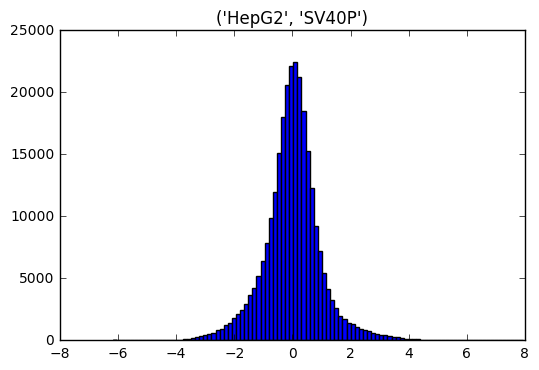

Variance for ('HepG2', 'SV40P') is 1.0
Min is -6.16867826813 and Max is 7.91908288808
Mean is -7.78651708023e-17


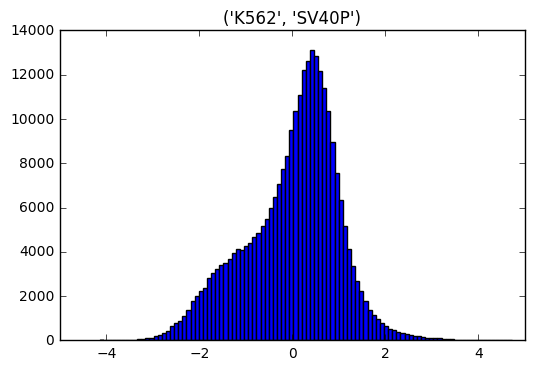

Variance for ('K562', 'SV40P') is 1.0
Min is -4.13787476365 and Max is 4.71189398336
Mean is 3.16327256385e-17


In [16]:
plot_scaled(scale)

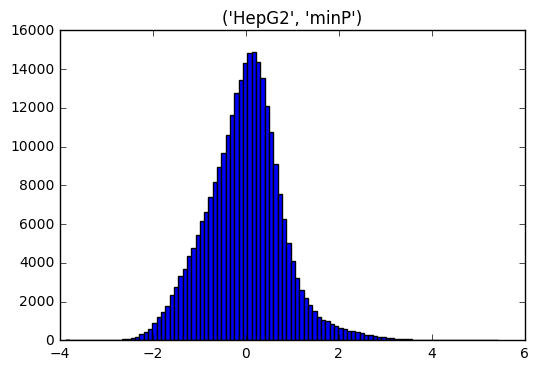

Variance for ('HepG2', 'minP') is 0.68943480489
Min is -3.87322958267 and Max is 5.42438004636
Mean is -0.0288508675719


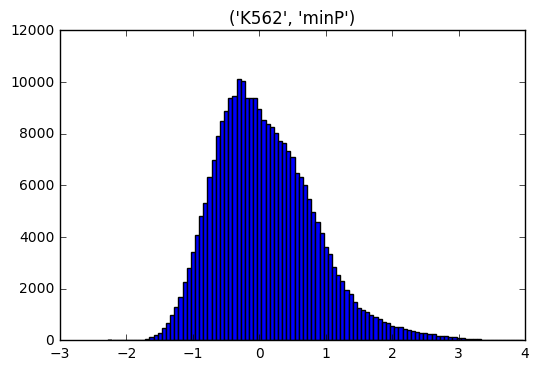

Variance for ('K562', 'minP') is 0.568684243862
Min is -2.2780977329 and Max is 3.96951822314
Mean is 0.0920133071193


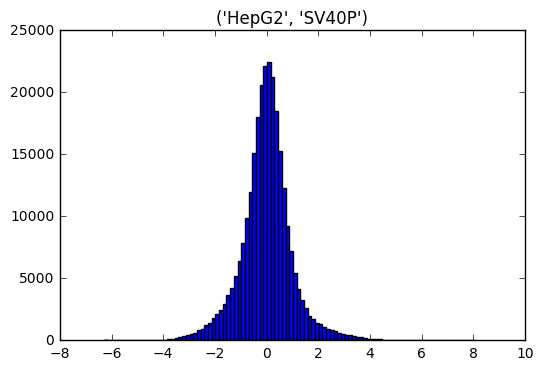

Variance for ('HepG2', 'SV40P') is 1.02977079932
Min is -6.27098465071 and Max is 8.02494052079
Mean is -0.0111565665761


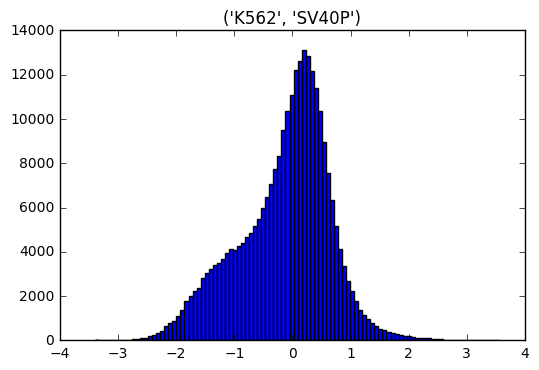

Variance for ('K562', 'SV40P') is 0.616998547495
Min is -3.38665821275 and Max is 3.56476921508
Mean is -0.136388409409


In [17]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
plot_scaled(scaler.fit_transform)